In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Carregar os dados
gdf = gpd.read_file("..\..\Data\Processed\PT-FireSprd_v2.1\L2_FireBehavior\PT-FireProg_v2.1_L2_model_Outubro.shp")

gdf = gdf.drop(columns=['inidoy', 'enddoy', 'ros_p_lg1'])

print("Primeiras linhas do dataset:")
print(gdf.head())
print("\nInformações do dataset:")
print(gdf.info())
print("\nColunas disponíveis:")
print(gdf.columns.tolist())

colunas_analise = gdf.columns.tolist()

Primeiras linhas do dataset:
         ros_p  duration_p     elev_av  aspect_sin  aspect_cos  landform  \
0  1199.641053         5.0  222.993924   -0.083639   -0.996496      21.0   
1   397.497644         4.0  167.295794    0.259744   -0.965678      22.0   
2  1092.753836         2.5  211.103842   -0.929666   -0.368404      21.0   
3   584.937417         7.5  184.752690    0.460585   -0.887616      21.0   
4   708.321556         1.5  170.930441   -0.994517    0.104575      21.0   

   land_use  1_3y_fir_p  3_8y_fir_p  8_ny_fir_p  ...  LCL_hPa_av  LCL_m_av  \
0       4.0         0.0         0.0   97.038153  ...  776.943906  2.187129   
1       4.0         0.0         0.0  100.000000  ...  799.280337  1.955263   
2       4.0         0.0         0.0   96.002558  ...  672.741767  3.322814   
3       4.0         0.0         0.0   98.711189  ...  716.408197  2.860403   
4       4.0         0.0         0.0    0.000000  ...  826.247787  1.686957   

   LFC_hPa_av  CCL_hPa_av  EL_m_av  LiftIdx_a


🚀 Running 1 clusters...

📊 RESULT — 1 CLUSTERS
Structural score (correlations): 0.0000
Average conditional ΔR²:         0.0000
Cuts: []

🔹 Cluster_1 — Top 20 correlations with ROS_p
   duration_p                r = -0.476 (pow)
   HDW_av                    r =  0.396 (exp)
   wv10_kh_av                r =  0.316 (pow)
   dfmc_av                   r = -0.299 (pow)
   VPD_Pa_av                 r =  0.295 (exp)
   BLH_m_av                  r =  0.291 (exp)
   gT_s_9_av                 r = -0.284 (pow)
   rh_2m_av                  r = -0.283 (pow)
   wv100_k_av                r =  0.278 (pow)
   Recirc                    r = -0.277 (pow)
   t_2m_C_av                 r =  0.265 (exp)
   CircVar                   r = -0.260 (pow)
   LCL_hPa_av                r = -0.255 (pow)
   LCL_m_av                  r =  0.252 (exp)
   f_start                   r = -0.246 (pow)
   LiftIdx_av                r = -0.246 (pow)
   wv_950_av                 r =  0.216 (pow)
   wv_500_av                 r =  0

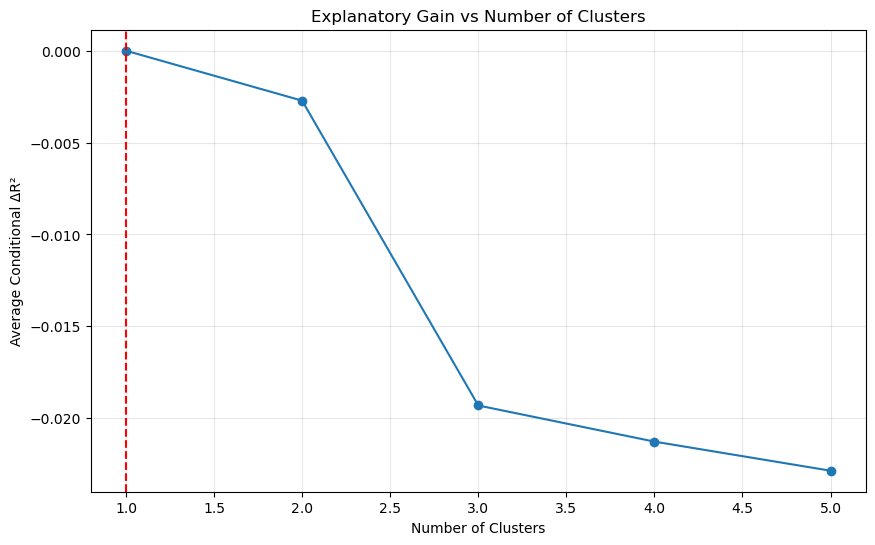

<Figure size 1000x600 with 0 Axes>

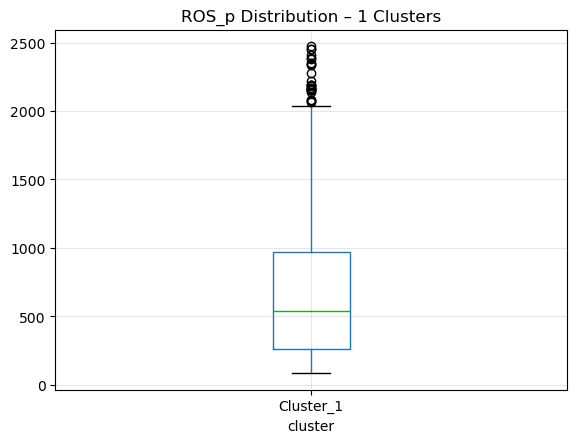

In [10]:
# ============================================================
# SEARCH AND EVALUATION OF CLUSTERS BASED ON ROS_p
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1. CORRELATION AND STRUCTURAL SCORE
# ============================================================

def best_correlation(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    if len(x) < 30:
        return None

    def slog(v):
        return np.sign(v) * np.log1p(np.abs(v))

    tests = {
        "linear": stats.pearsonr(y, x),
        "exp": stats.pearsonr(slog(y), x),
        "pow": stats.pearsonr(slog(y), slog(x)),
        "log": stats.pearsonr(y, slog(x)),
    }

    valid = [(k, r, p) for k, (r, p) in tests.items() if p < 0.05]
    return max(valid, key=lambda v: abs(v[1])) if valid else None


def cluster_score(groups):
    top_corrs = []

    for g in groups:
        corr = {}
        for col in g.select_dtypes("number").columns[:30]:
            if col == "ros_p":
                continue

            r = best_correlation(g[col].values, g["ros_p"].values)
            if r and abs(r[1]) > 0.1:
                corr[col] = r[1]

        top_corrs.append(dict(sorted(corr.items(),
                                     key=lambda x: abs(x[1]),
                                     reverse=True)[:10]))

    diffs = []
    for a, b in combinations(top_corrs, 2):
        common = set(a) & set(b)
        diffs.extend([abs(a[v] - b[v]) for v in common])

    return np.mean(diffs) if diffs else 0


# ============================================================
# 2. CONDITIONAL ΔR² SCORE
# ============================================================

def delta_r2_score(df, groups):
    gains = []

    for col in df.select_dtypes("number").columns:
        if col == "ros_p":
            continue

        r_global = best_correlation(df[col].values, df["ros_p"].values)
        if not r_global:
            continue

        r2_global = r_global[1] ** 2

        r2_cond = 0
        total = len(df)

        for g in groups:
            r = best_correlation(g[col].values, g["ros_p"].values)
            if r:
                r2_cond += (len(g) / total) * (r[1] ** 2)

        gains.append(r2_cond - r2_global)

    return np.mean(gains) if gains else 0.0


# ============================================================
# 3. CANDIDATES AND GROUPS
# ============================================================

def generate_candidates(df, n=10):
    ros = df["ros_p"].dropna().values
    p = np.percentile(ros, np.linspace(5, 95, n))
    u = np.linspace(ros.min(), ros.max(), n // 2)
    return sorted(set(np.concatenate([p, u])))


def create_groups(df, cuts):
    cuts = sorted(cuts)
    bins = [-np.inf] + cuts + [np.inf]

    return [
        df[(df.ros_p > bins[i]) & (df.ros_p <= bins[i + 1])]
        for i in range(len(bins) - 1)
    ]


# ============================================================
# 4. SEARCH FOR CUTS
# ============================================================

def search_cuts(df, n_cuts, candidates, min_points=30):
    if n_cuts == 0:
        return [], cluster_score([df])

    best_score = -1
    best_cut = []

    for comb in combinations(candidates, n_cuts):
        groups = create_groups(df, comb)

        if any(len(g) < min_points for g in groups):
            continue

        score = cluster_score(groups)
        if score > best_score:
            best_score = score
            best_cut = list(comb)

    return best_cut, best_score


# ============================================================
# 5. PRINT TOP CORRELATIONS PER CLUSTER
# ============================================================

def print_top_correlations(df_cluster, cluster_name, top_n=20):
    print(f"\n🔹 {cluster_name} — Top {top_n} correlations with ROS_p")

    corr = {}
    for col in df_cluster.select_dtypes("number").columns:
        if col == "ros_p":
            continue

        r = best_correlation(df_cluster[col].values, df_cluster["ros_p"].values)
        if r:
            corr[col] = (r[0], r[1])

    if not corr:
        print("   (No significant correlations)")
        return

    top = sorted(corr.items(), key=lambda x: abs(x[1][1]), reverse=True)[:top_n]
    for v, (typ, r_val) in top:
        print(f"   {v:<25} r = {r_val: .3f} ({typ})")


# ============================================================
# 6. RUN FOR N CLUSTERS
# ============================================================

def run_n_clusters(df, n_clusters):
    candidates = generate_candidates(df)
    cuts, score = search_cuts(df, n_clusters - 1, candidates)

    bins = [-np.inf] + cuts + [np.inf]
    labels = [f"Cluster_{i+1}" for i in range(n_clusters)]

    df_out = df.copy()
    df_out["cluster"] = pd.cut(df_out.ros_p, bins=bins, labels=labels)

    groups = [df_out[df_out.cluster == l] for l in labels]

    # Conditional ΔR²
    delta_r2 = 0.0 if n_clusters == 1 else delta_r2_score(df_out, groups)

    cluster_stats = (
        df_out.groupby("cluster")["ros_p"]
        .agg(n="count", min="min", max="max", mean="mean", std="std")
        .reset_index()
    )

    print(f"\n==============================")
    print(f"📊 RESULT — {n_clusters} CLUSTERS")
    print(f"Structural score (correlations): {score:.4f}")
    print(f"Average conditional ΔR²:         {delta_r2:.4f}")
    print("Cuts:", cuts)

    for label in labels:
        g = df_out[df_out.cluster == label]
        print_top_correlations(g, label)

    return {
        "n_clusters": n_clusters,
        "score": score,
        "delta_r2": delta_r2,
        "cuts": cuts,
        "stats": cluster_stats,
        "df": df_out,
    }


# ============================================================
# 7. RUN 1 → 5 CLUSTERS
# ============================================================

results = []

for k in range(1, 6):
    print(f"\n🚀 Running {k} clusters...")
    results.append(run_n_clusters(gdf, k))


# ============================================================
# 8. COMPARISON OF RESULTS
# ============================================================

df_comparison = pd.DataFrame({
    "n_clusters": [r["n_clusters"] for r in results],
    "structural_score": [r["score"] for r in results],
    "delta_r2": [r["delta_r2"] for r in results],
    "min_cluster": [r["stats"]["n"].min() for r in results],
}).sort_values("delta_r2", ascending=False)

best_result = results[df_comparison.index[0]]

print("\n🏆 BEST CONFIGURATION (EXPLANATORY GAIN)")
print(df_comparison.head(1))
print("Cuts:", best_result["cuts"])


# ============================================================
# 9. PLOTS
# ============================================================

plt.figure(figsize=(10, 6))
plt.plot(df_comparison.n_clusters, df_comparison.delta_r2, "o-")
plt.axvline(best_result["n_clusters"], color="red", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Conditional ΔR²")
plt.title("Explanatory Gain vs Number of Clusters")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
best_result["df"].boxplot(column="ros_p", by="cluster")
plt.title(f"ROS_p Distribution – {best_result['n_clusters']} Clusters")
plt.suptitle("")
plt.grid(alpha=0.3)
plt.show()


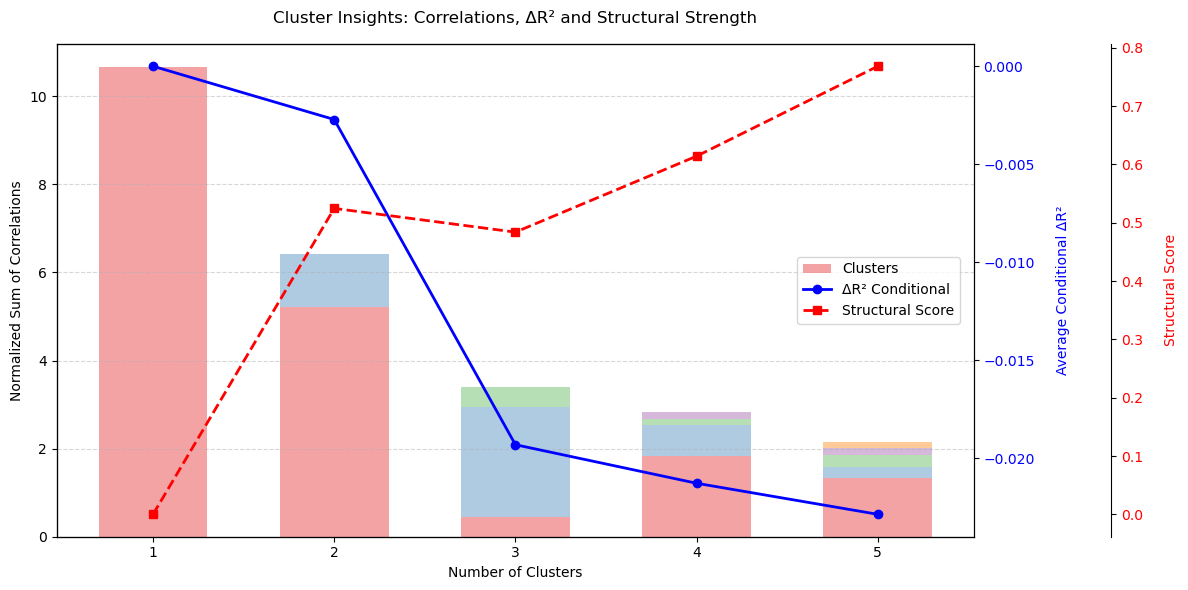

In [19]:
import numpy as np
import matplotlib.pyplot as plt

x_vals = df_comparison['n_clusters'].values
bar_width = 0.6  # largura da barra
max_clusters = max(r['n_clusters'] for r in results)

fig, ax1 = plt.subplots(figsize=(12, 6))

# ----------------- Stacked bars -----------------
for idx, n in enumerate(x_vals):
    r = next(r for r in results if r["n_clusters"] == n)
    df_clusters = r['df']
    labels = df_clusters['cluster'].cat.categories

    cluster_sums = []
    for l in labels:
        dfc = df_clusters[df_clusters['cluster'] == l]
        corr_sum = 0
        for col in dfc.select_dtypes("number").columns:
            if col == "ros_p":
                continue
            r_corr = best_correlation(dfc[col].values, dfc['ros_p'].values)
            if r_corr:
                corr_sum += abs(r_corr[1])
        cluster_sums.append(corr_sum / len(labels))

    # empilhar verticalmente
    bottom = 0
    for i, val in enumerate(cluster_sums):
        ax1.bar(n, val, width=bar_width, bottom=bottom,
                label="Clusters" if idx == 0 and i == 0 else None, alpha=0.4, color=plt.cm.Set1(i))
        bottom += val

# ----------------- Gridlines -----------------
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Normalized Sum of Correlations", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# ----------------- ΔR² Conditional -----------------
ax2 = ax1.twinx()
ax2.plot(x_vals, df_comparison.delta_r2, "o-", color='blue', label="ΔR² Conditional", linewidth=2)
ax2.set_ylabel("Average Conditional ΔR²", color='blue', labelpad=15)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.grid(False)

# ----------------- Structural Score -----------------
ax3 = ax1.twinx()
ax3.spines['right'].set_position(("axes", 1.15))
ax3.plot(x_vals, df_comparison.structural_score, "s--", color='red', label="Structural Score", linewidth=2)
ax3.set_ylabel("Structural Score", color='red', labelpad=15)
ax3.tick_params(axis='y', labelcolor='red')
ax3.grid(False)

# ----------------- Legenda à direita -----------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3,
           loc='center left', bbox_to_anchor=(0.8, 0.5))  # à direita do gráfico

plt.title("Cluster Insights: Correlations, ΔR² and Structural Strength", pad=15)
plt.tight_layout()
plt.show()



CLUSTER_1 | N = 416
Top 20 correlations with ROS_p
Var | Type | r | p
------------------------------------------------------------
HDW_av                    Lin  +0.301  p=3.52e-10
dfmc_av                   Pow  -0.274  p=1.31e-08
VPD_Pa_av                 Exp  +0.263  p=5.42e-08
rh_2m_av                  Exp  -0.261  p=6.62e-08
BLH_m_av                  Exp  +0.241  p=6.27e-07
duration_p                Lin  -0.241  p=6.77e-07
LCL_hPa_av                Exp  -0.240  p=7.48e-07
t_2m_C_av                 Exp  +0.238  p=8.65e-07
LCL_m_av                  Pow  +0.238  p=9.4e-07
f_start                   Log  -0.203  p=3.09e-05
wv10_kh_av                Log  +0.200  p=4.08e-05
LiftIdx_av                Pow  -0.199  p=4.46e-05
rh_950_av                 Exp  -0.196  p=5.64e-05
Recirc                    Exp  -0.192  p=0.000138
CircVar                   Log  -0.174  p=0.000574
wv100_k_av                Log  +0.159  p=0.00116
gT_9_8_av                 Exp  -0.156  p=0.00138
t_950_av             


CLUSTER_4 | N = 113
Top 20 correlations with ROS_p
Var | Type | r | p
------------------------------------------------------------
No significant correlations.

CLUSTER_5 | N = 110
Top 20 correlations with ROS_p
Var | Type | r | p
------------------------------------------------------------
vwv_500_av                Pow  -0.310  p=0.000965
wv_300_av                 Exp  -0.247  p=0.00925
duration_p                Lin  -0.204  p=0.0322


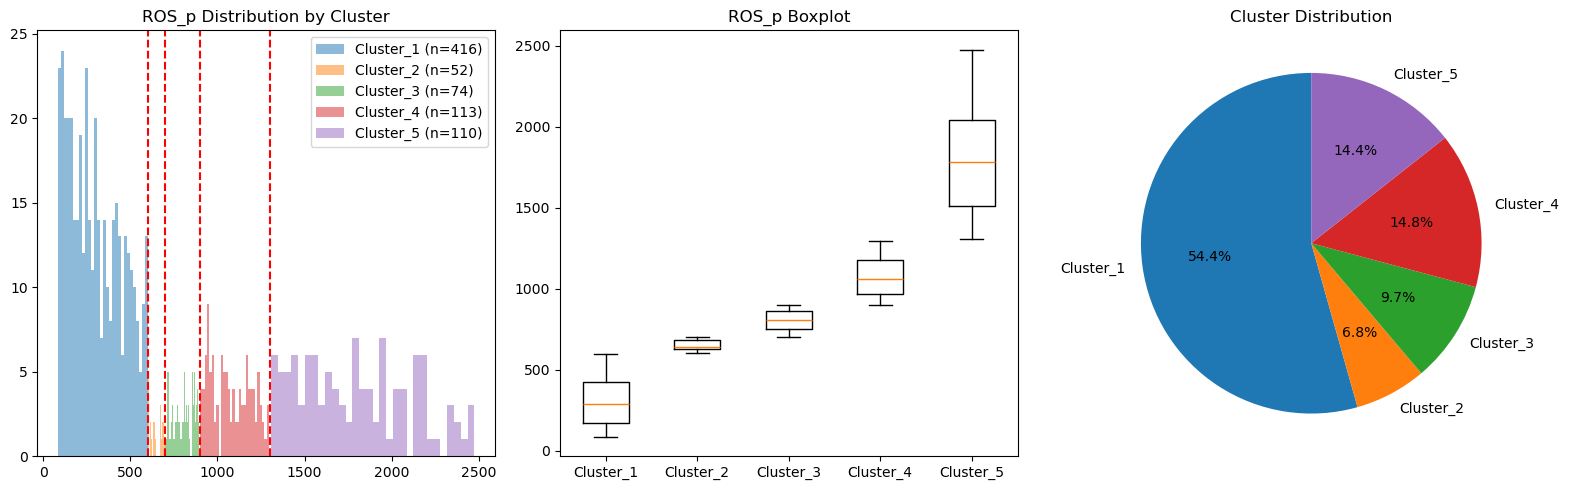

In [4]:
# ================================================
# SIMPLIFIED CLUSTERING (GENERIC)
# - Works for any number of clusters
# - No minimum points per cluster
# - Maintains main plots
# - Prints Top 20 correlations per cluster
# - Correlation types: Lin | Exp | Pow | Log
# ================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ================= CONFIGURATION ==================
# Define only the cut points
# n_clusters = len(cut_points) + 1
cut_points = [600, 700, 900, 1300]
strong_corr_threshold = 0.15

# ================= DATA ==========================
# gdf must exist and contain 'ros_p'

# Valid numeric variables (>75% non-null)
valid_vars = [
    c for c in gdf.columns
    if c != 'geometry'
    and gdf[c].dtype in ['float64', 'int64', 'float32', 'int32']
    and gdf[c].notna().mean() >= 0.75
    and c != 'ros_p'
]

# ================= FUNCTIONS =======================
def safe_log(x):
    return np.sign(x) * np.log(np.abs(x) + 1)


def best_correlation(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[mask], y[mask]

    if len(x) < 10:
        return None

    try:
        res = []

        # Linear
        r, p = stats.pearsonr(y, x)
        res.append(('Lin', r, p))

        # Exponential (log(y) vs x)
        ylog = safe_log(y)
        r, p = stats.pearsonr(ylog, x)
        res.append(('Exp', r, p))

        # Power (log(y) vs log(x))
        xlog = safe_log(x)
        r, p = stats.pearsonr(ylog, xlog)
        res.append(('Pow', r, p))

        # Logarithmic (y vs log(x))
        r, p = stats.pearsonr(y, xlog)
        res.append(('Log', r, p))

        # Keep only significant correlations
        res = [r for r in res if not np.isnan(r[1]) and r[2] < 0.05]
        if not res:
            return None

        # Return the one with highest |r|
        return max(res, key=lambda z: abs(z[1]))

    except Exception:
        return None


# ================= CLUSTERS ======================
bins = [-np.inf] + cut_points + [np.inf]
labels = [f'Cluster_{i+1}' for i in range(len(bins) - 1)]

gdf['cluster'] = pd.cut(
    gdf['ros_p'],
    bins=bins,
    labels=labels
)

# ================= ANALYSIS ======================
results = {}

for cl in labels:
    dfc = gdf[gdf['cluster'] == cl]

    correlations = []
    for v in valid_vars:
        r = best_correlation(dfc[v].values, dfc['ros_p'].values)
        if r and abs(r[1]) >= strong_corr_threshold:
            correlations.append((v, r[0], r[1], r[2]))

    correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    results[cl] = correlations[:20]

    # -------- PRINT --------
    print("\n" + "=" * 60)
    print(f"{cl.upper()} | N = {len(dfc)}")
    print("Top 20 correlations with ROS_p")
    print("Var | Type | r | p")
    print("-" * 60)

    if not results[cl]:
        print("No significant correlations.")
    else:
        for v, t, r, p in results[cl]:
            sign = '+' if r > 0 else '-'
            print(f"{v:25s} {t:>3s}  {sign}{abs(r):.3f}  p={p:.3g}")

# ================= PLOTS =========================
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Histogram of ROS_p
for cl in labels:
    data = gdf[gdf['cluster'] == cl]['ros_p']
    axs[0].hist(data, bins=30, alpha=0.5, label=f"{cl} (n={len(data)})")

for c in cut_points:
    axs[0].axvline(c, color='red', ls='--')

axs[0].set_title('ROS_p Distribution by Cluster')
axs[0].legend()

# Boxplot of ROS_p
axs[1].boxplot(
    [gdf[gdf['cluster'] == cl]['ros_p'] for cl in labels],
    labels=labels
)
axs[1].set_title('ROS_p Boxplot')

# Cluster size distribution
sizes = [len(gdf[gdf['cluster'] == cl]) for cl in labels]
axs[2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Cluster Distribution')

plt.tight_layout()
plt.show()


In [5]:
# ================= TOP VARIABLES AND GLOBAL TRANSFORMATION ===================
top_vars_set = set()
best_transformation = {}  # variable -> transformation type

# Collect top 20 variables from each cluster and their transformation
for cl, corrs in results.items():
    for v, trans_type, r_val, p_val in corrs[:20]:
        top_vars_set.add(v)
        if v not in best_transformation:
            best_transformation[v] = trans_type  # take transformation from the cluster where it first appeared

top_vars_all_clusters = list(top_vars_set)
print("Top variables across all clusters:", top_vars_all_clusters)
print("Assigned transformations:", best_transformation)

# ================= CALCULATE CORRELATIONS FOR ALL CLUSTERS ===================
corr_top_vars = {cl: [] for cl in labels}

for cl in labels:
    dfc = gdf[gdf['cluster'] == cl]

    for v in top_vars_all_clusters:
        # Recalculate correlation without filtering by p-value
        mask = ~np.isnan(dfc[v].values) & ~np.isnan(dfc['ros_p'].values)
        x, y = dfc[v].values[mask], dfc['ros_p'].values[mask]
        if len(x) < 10:
            continue

        # Apply global transformation
        trans_type = best_transformation[v]
        if trans_type == 'Lin':
            x_plot, y_plot = x, y
        elif trans_type == 'Exp':
            x_plot, y_plot = x, safe_log(y)
        elif trans_type == 'Pow':
            x_plot, y_plot = safe_log(x), safe_log(y)
        elif trans_type == 'Log':
            x_plot, y_plot = safe_log(x), y
        else:
            x_plot, y_plot = x, y

        # Filter valid values
        mask_plot = np.isfinite(x_plot) & np.isfinite(y_plot)
        x_plot_f, y_plot_f = x_plot[mask_plot], y_plot[mask_plot]
        if len(x_plot_f) < 2:
            continue

        # Calculate correlation on global transformation
        try:
            r, p = stats.pearsonr(x_plot_f, y_plot_f)
            corr_top_vars[cl].append((v, trans_type, r, p))
        except:
            continue

# Print correlations
for cl in labels:
    if cl in corr_top_vars:
        print(f"\nCluster {cl} - correlations for top variables (global transformation)")
        print("Var | Type | r | p")
        for v, t, r, p in corr_top_vars[cl]:
            sign = '+' if r > 0 else '-'
            print(f"{v:25s} {t:>3s}  {sign}{abs(r):.3f}  p={p:.3g}")


Top variables across all clusters: ['wv10_kh_av', 'rh_950_av', 'wco_700_av', 'landform', 'gT_9_8_av', 'wv100_k_av', 't_700_av', 'Recirc', 'wv_300_av', 't_850_av', 'LCL_hPa_av', 'LiftIdx_av', 'wSsin_7_av', 'BLH_m_av', 'gp_500_av', 'gp_700_av', 'VPD_Pa_av', 'rh_2m_av', 't_950_av', 'LCL_m_av', 'vwv_500_av', 't_2m_C_av', 'duration_p', 'rh_300_av', 'f_start', 'CircVar', 'dfmc_av', 'gp_300_av', 'HDW_av']
Assigned transformations: {'HDW_av': 'Lin', 'dfmc_av': 'Pow', 'VPD_Pa_av': 'Exp', 'rh_2m_av': 'Exp', 'BLH_m_av': 'Exp', 'duration_p': 'Lin', 'LCL_hPa_av': 'Exp', 't_2m_C_av': 'Exp', 'LCL_m_av': 'Pow', 'f_start': 'Log', 'wv10_kh_av': 'Log', 'LiftIdx_av': 'Pow', 'rh_950_av': 'Exp', 'Recirc': 'Exp', 'CircVar': 'Log', 'wv100_k_av': 'Log', 'gT_9_8_av': 'Exp', 't_950_av': 'Exp', 'wSsin_7_av': 'Exp', 't_850_av': 'Log', 'wco_700_av': 'Log', 'landform': 'Log', 'gp_500_av': 'Log', 'gp_700_av': 'Log', 't_700_av': 'Log', 'gp_300_av': 'Log', 'rh_300_av': 'Exp', 'vwv_500_av': 'Pow', 'wv_300_av': 'Exp'}

C

Clusters used: ['Cluster_1', 'Cluster_2']
Variables to plot: ['HDW_av', 'dfmc_av', 'VPD_Pa_av', 'rh_2m_av', 'BLH_m_av', 'duration_p', 'LCL_hPa_av', 't_2m_C_av', 'LCL_m_av', 'f_start', 'wv10_kh_av', 'LiftIdx_av', 'rh_950_av', 'Recirc', 'CircVar', 'wv100_k_av', 'gT_9_8_av', 't_950_av', 'wSsin_7_av', 't_850_av', 'wco_700_av', 'landform', 'gp_500_av', 'gp_700_av', 't_700_av', 'gp_300_av']


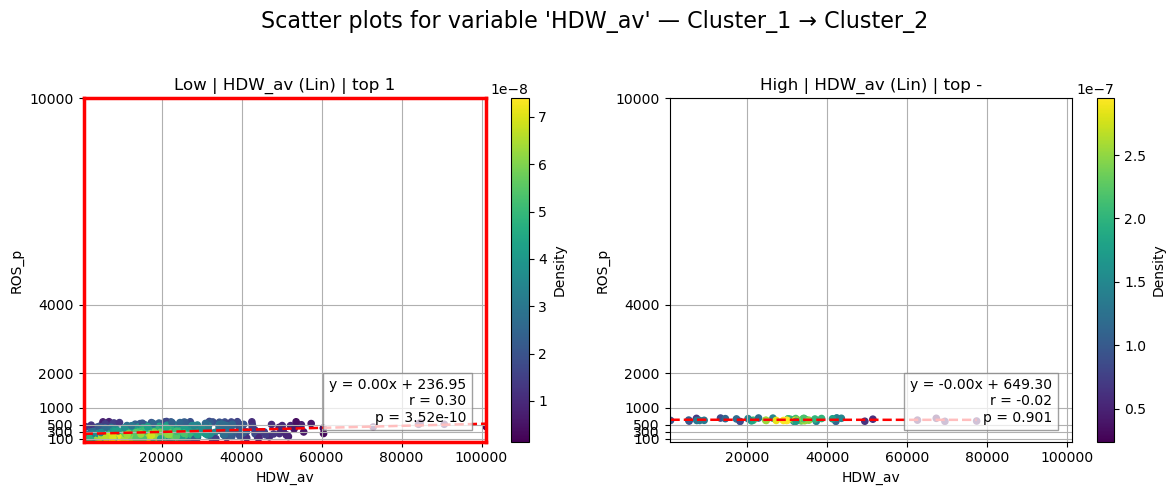

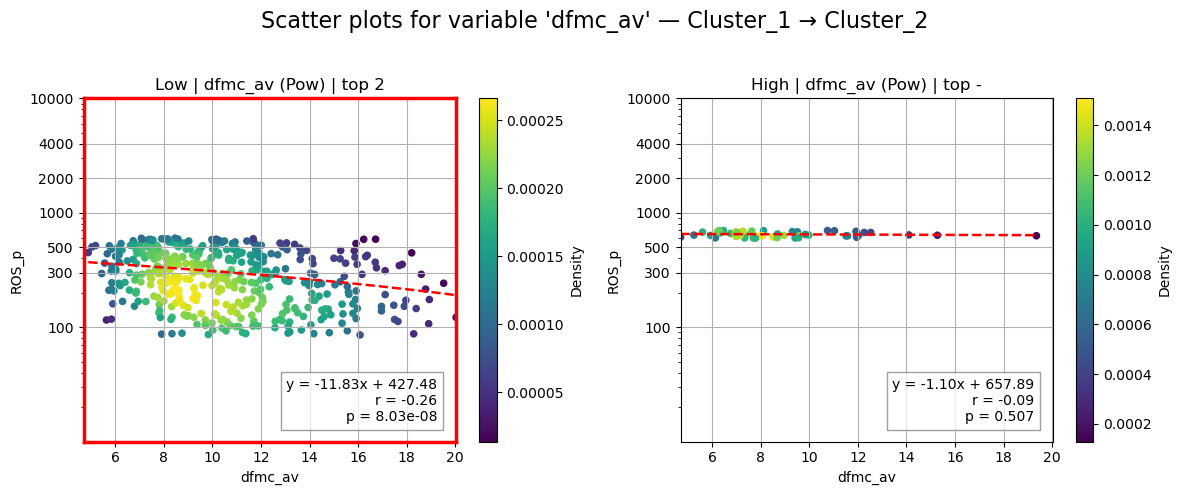

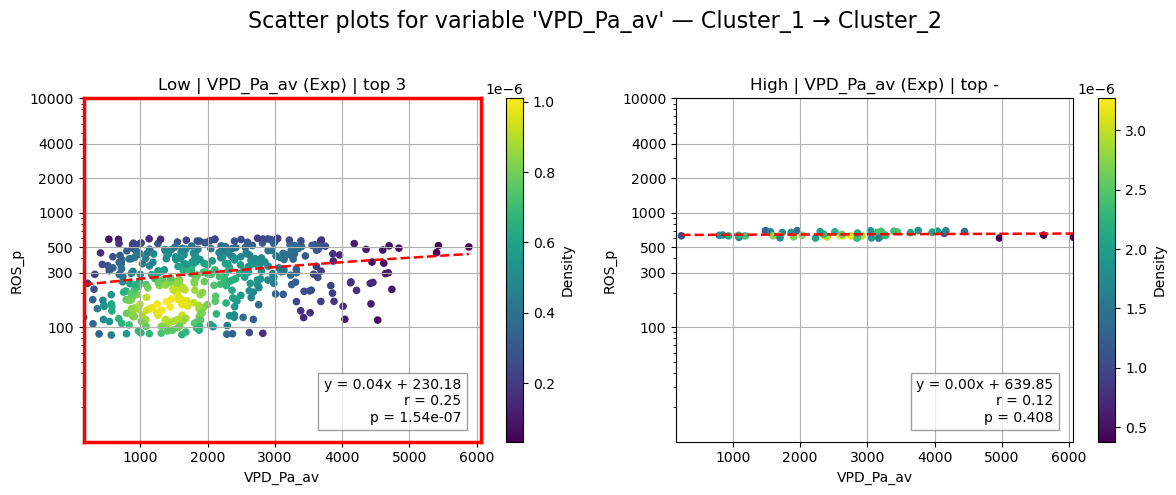

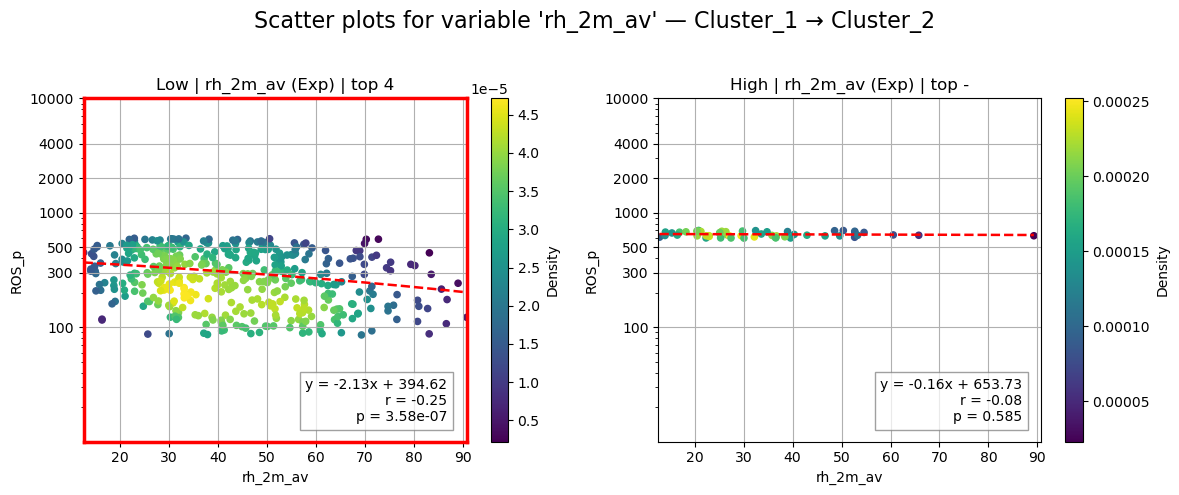

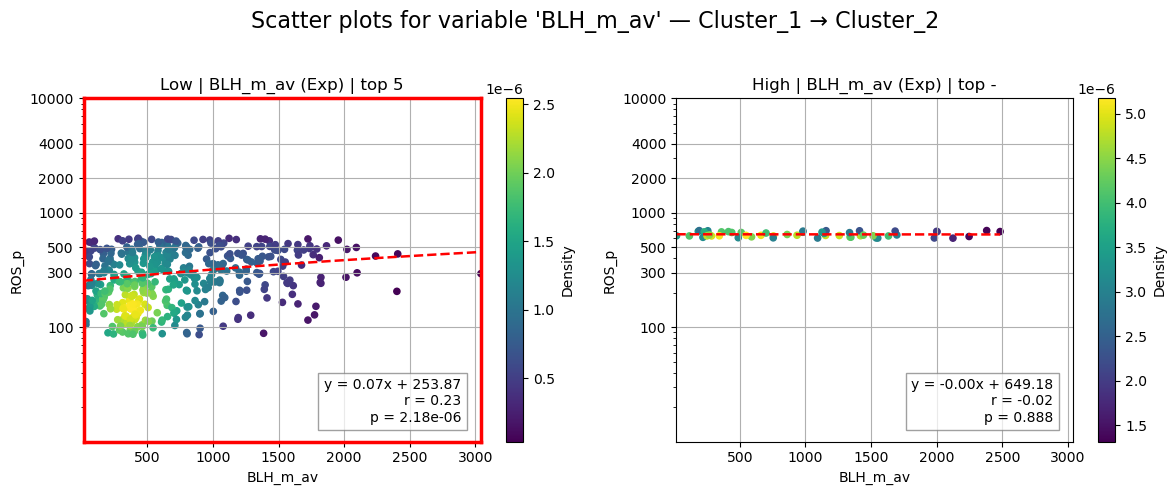

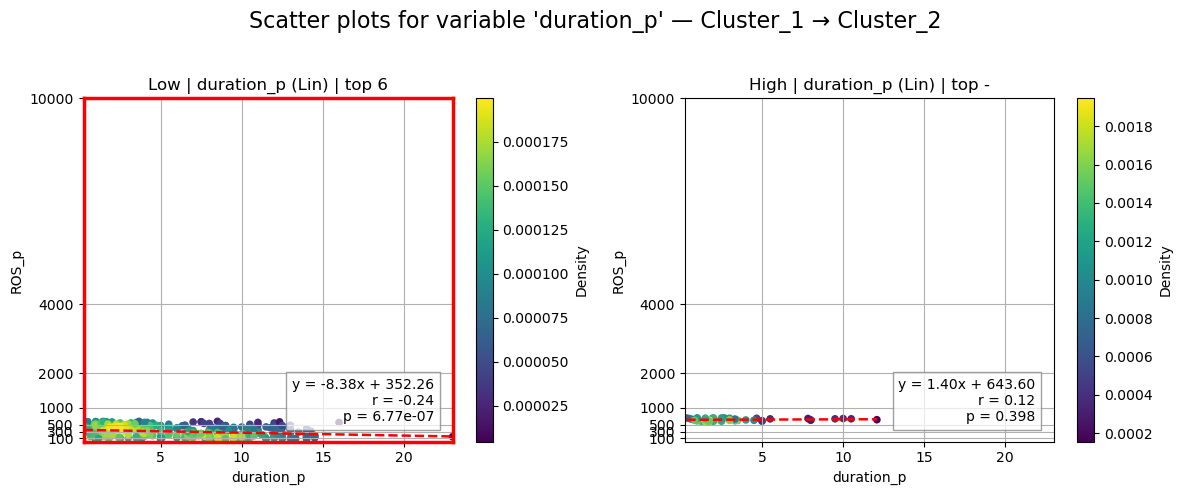

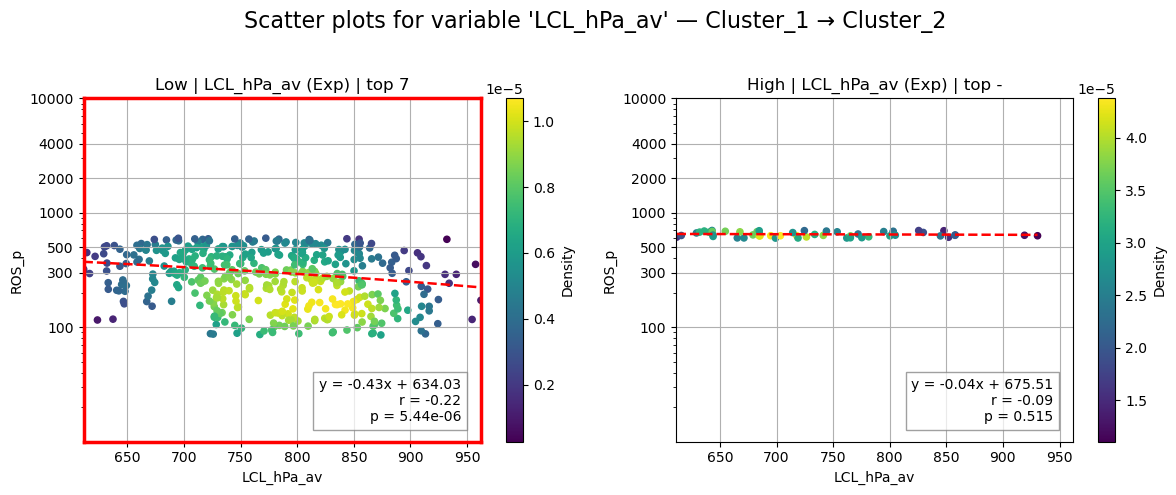

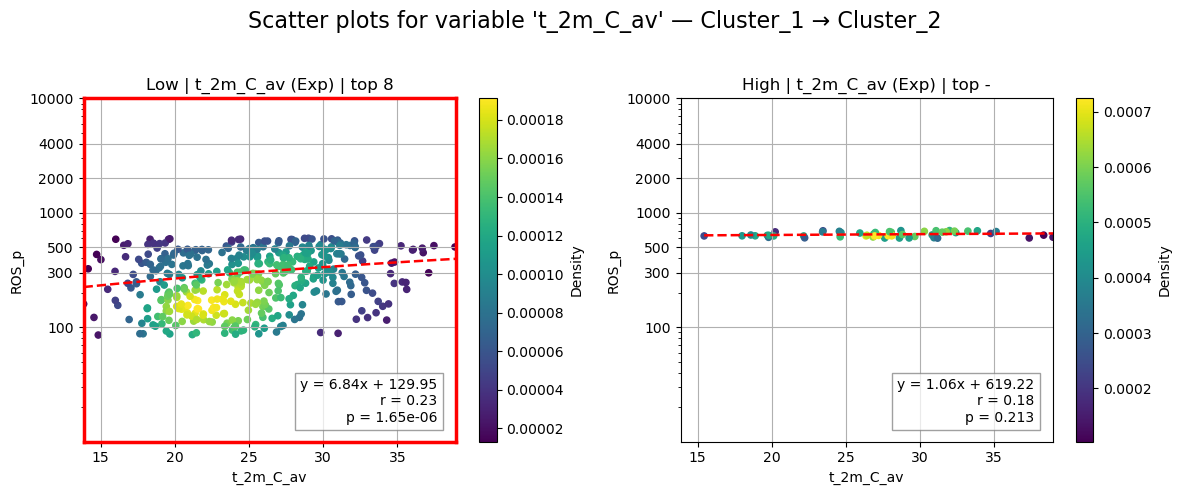

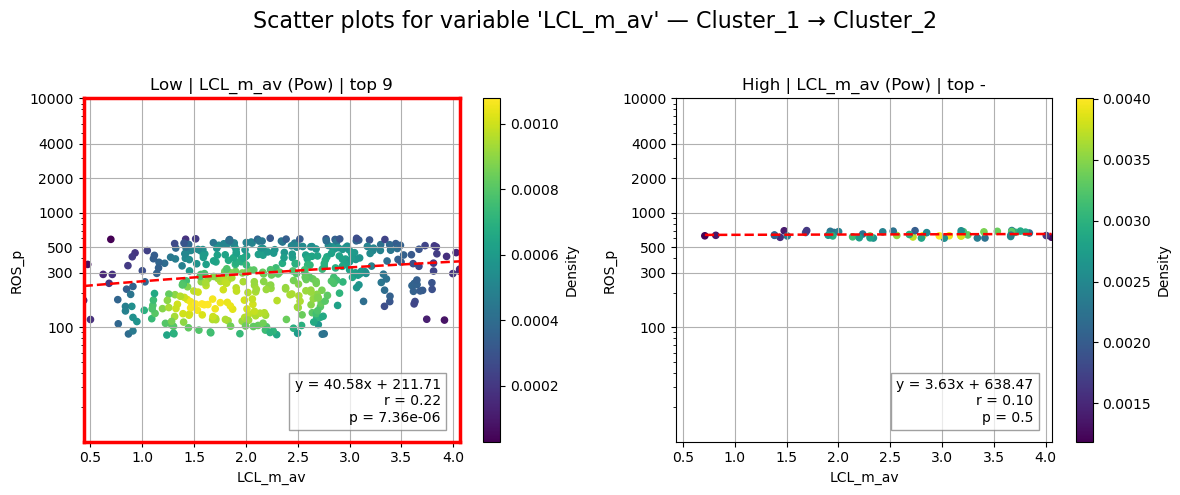

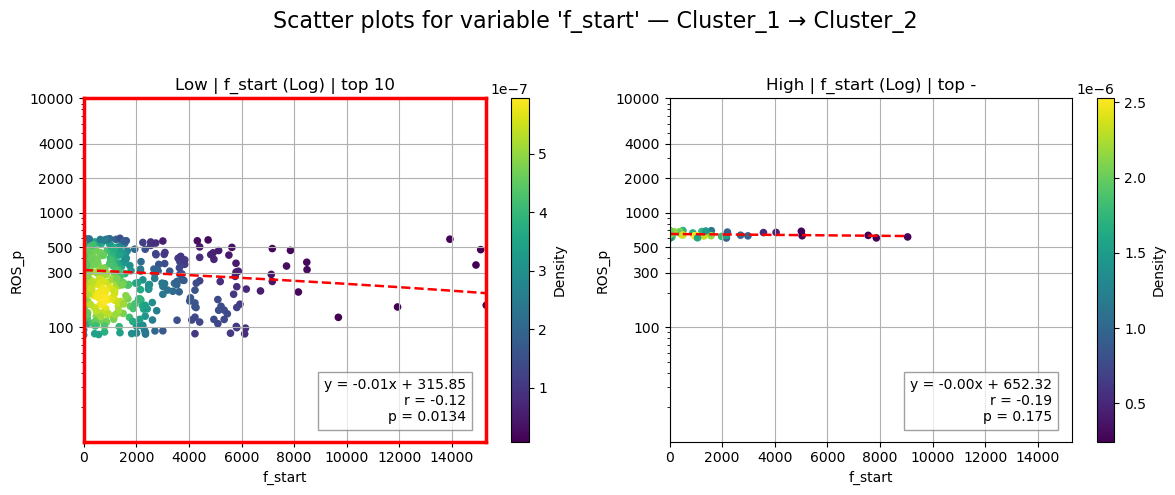

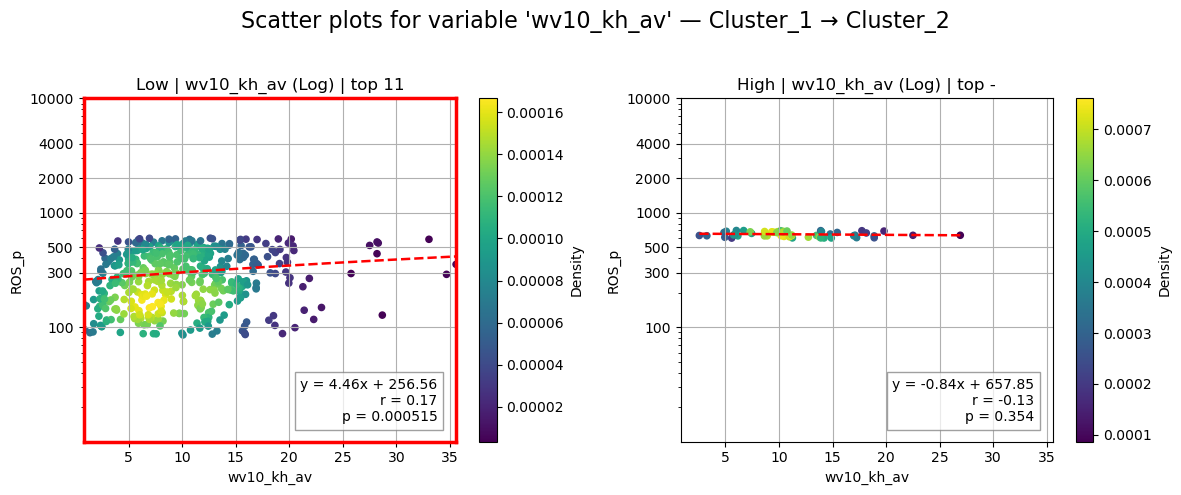

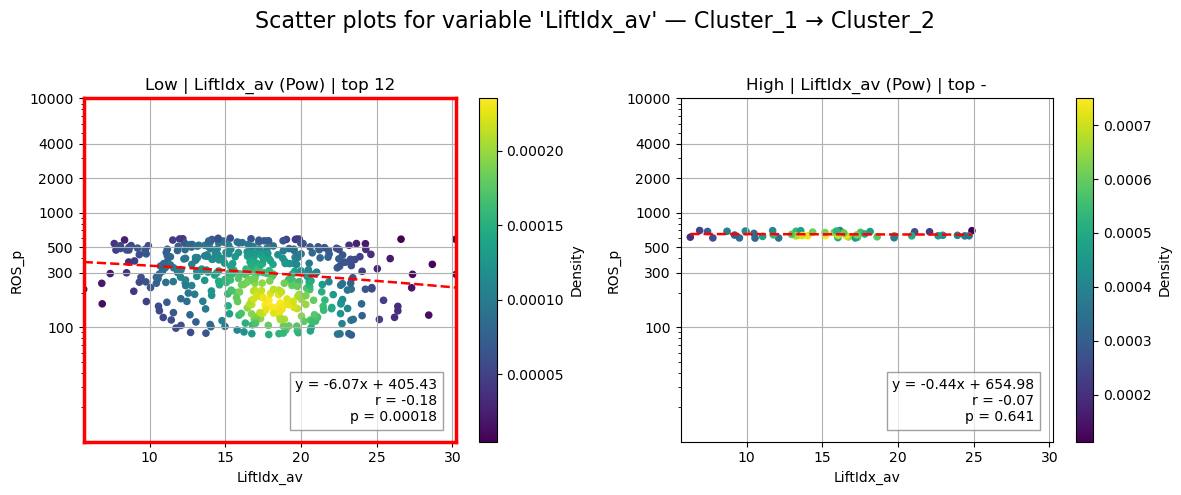

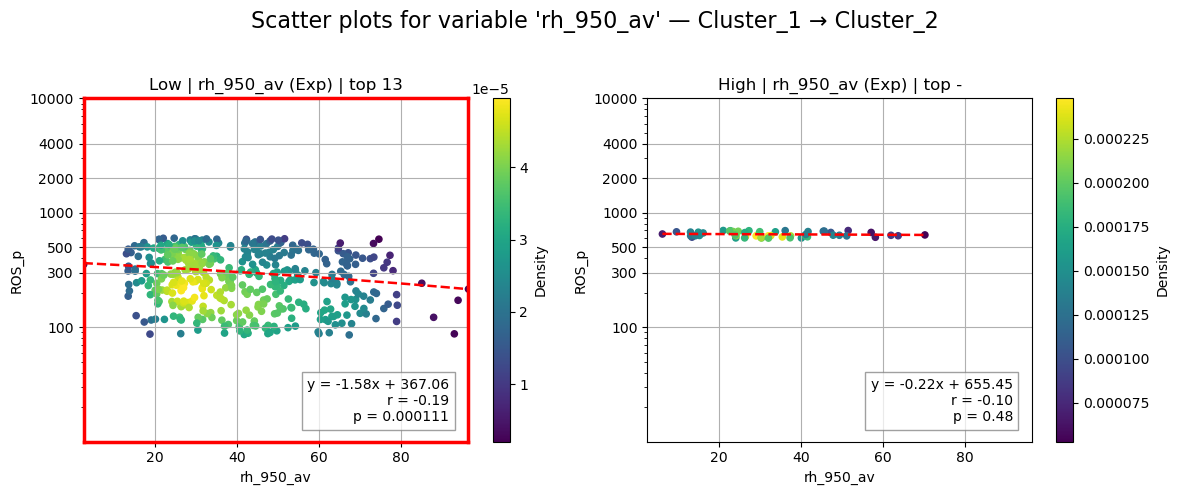

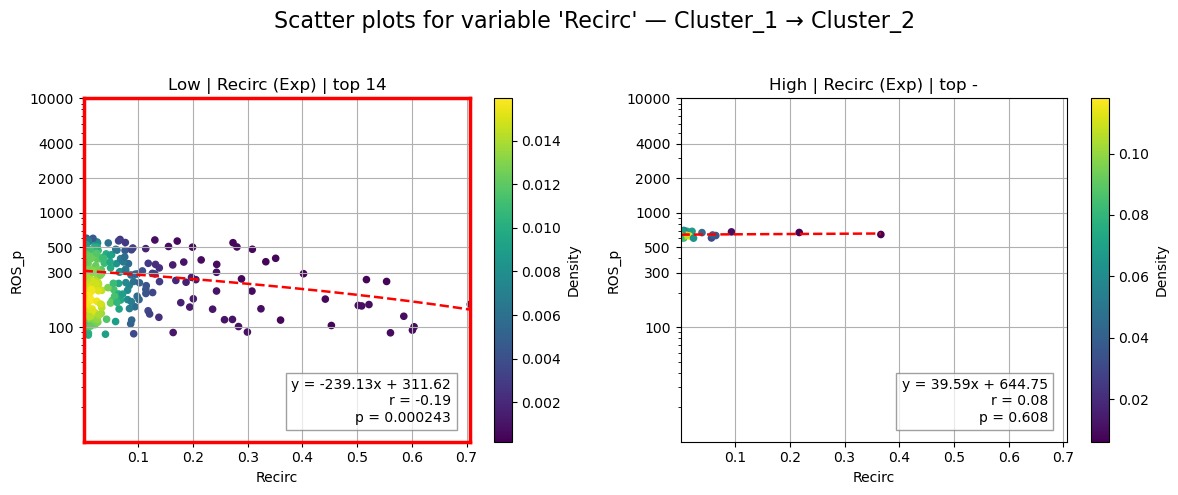

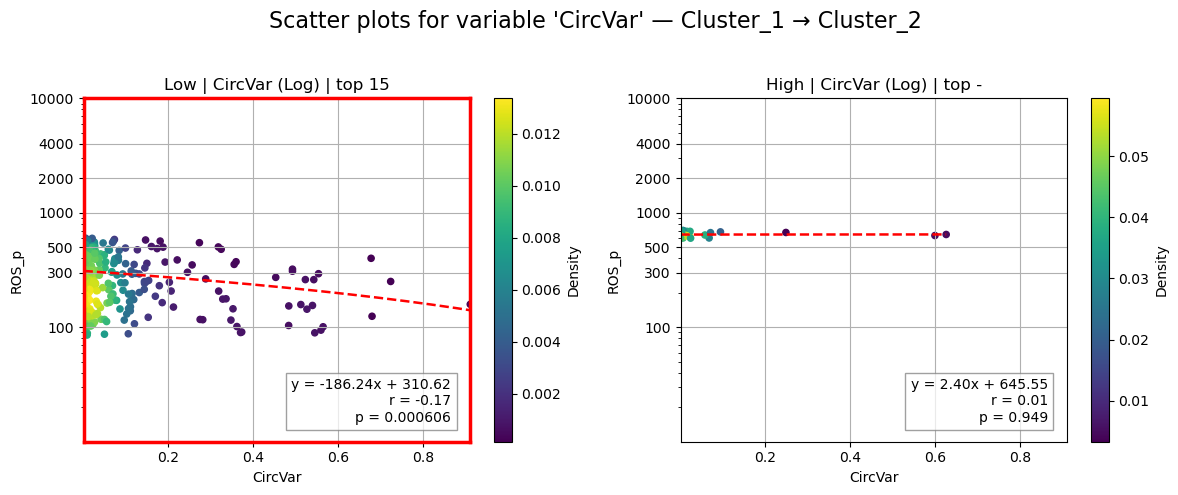

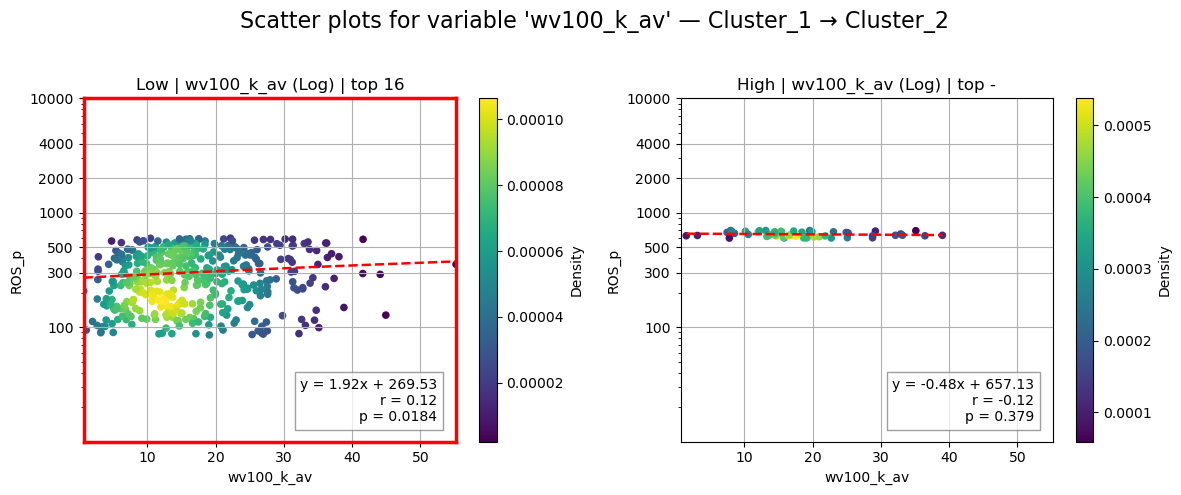

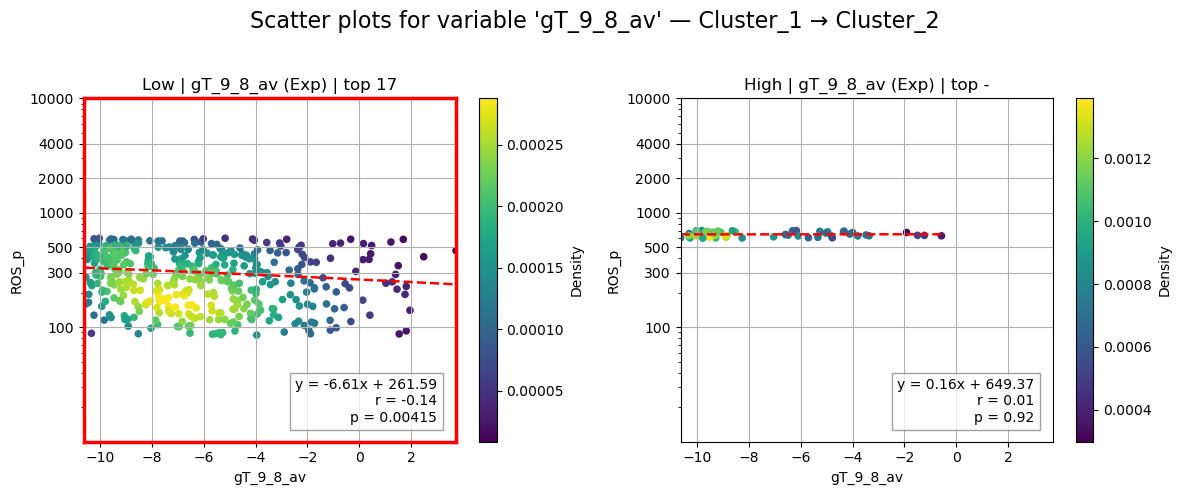

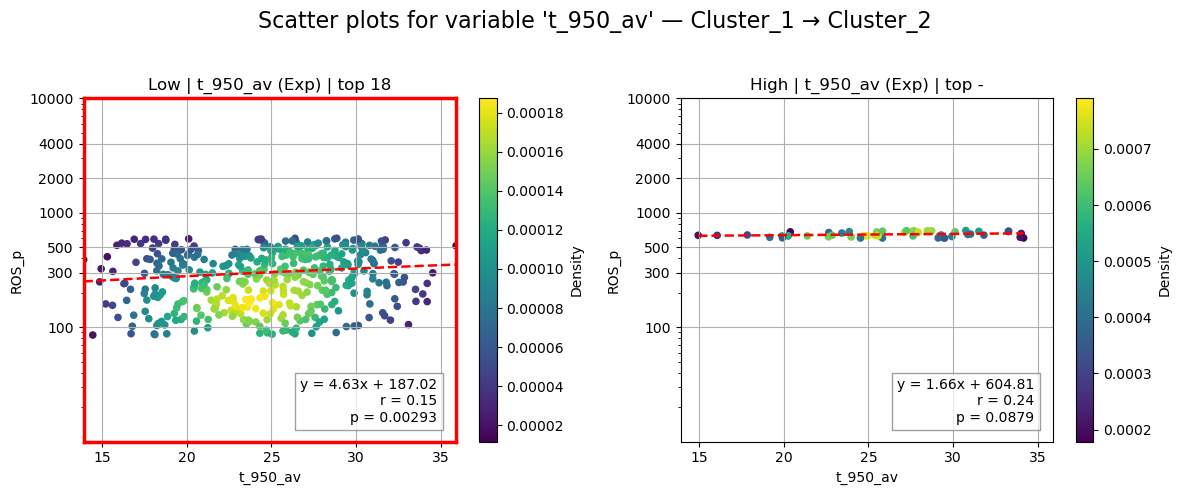

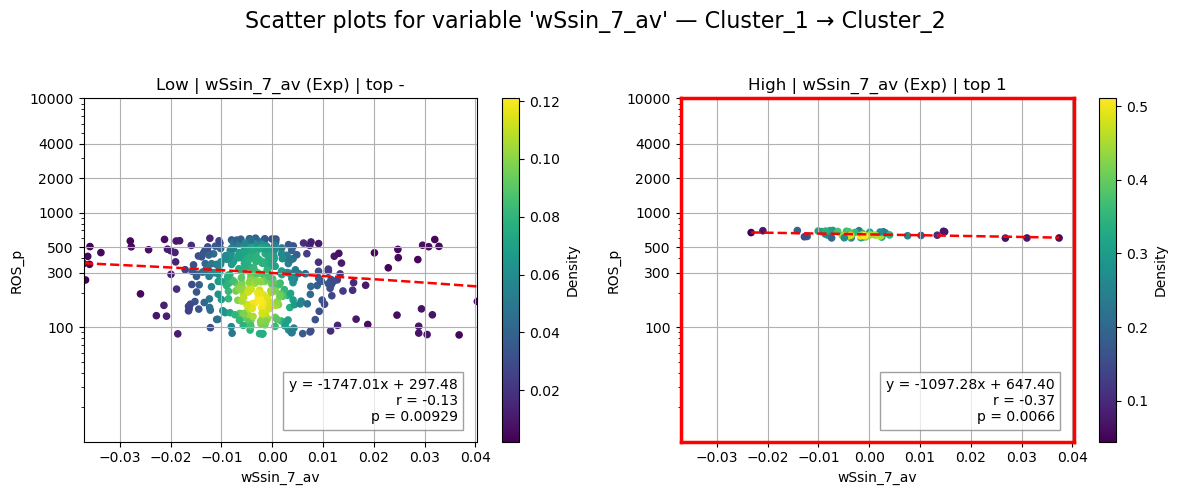

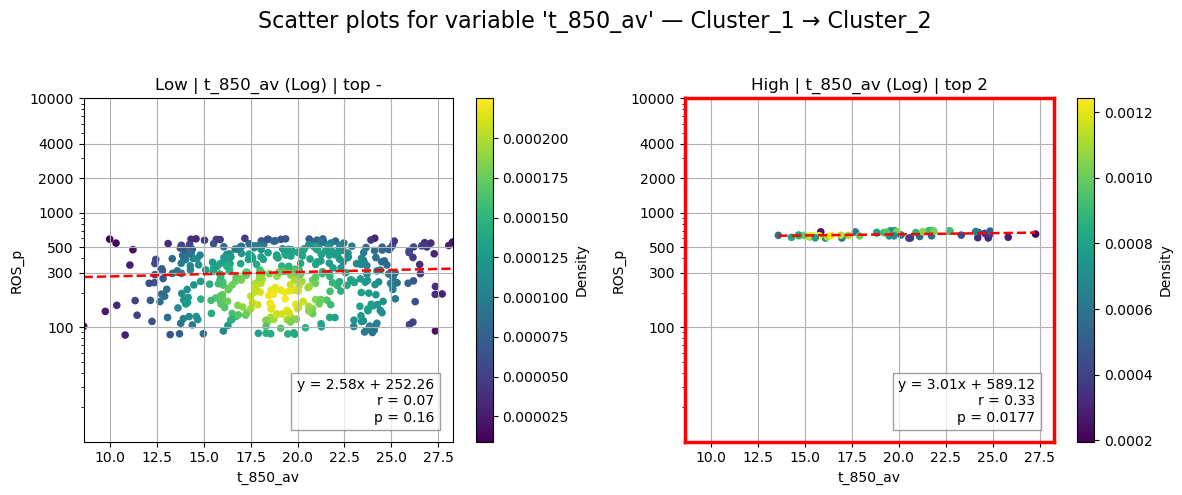

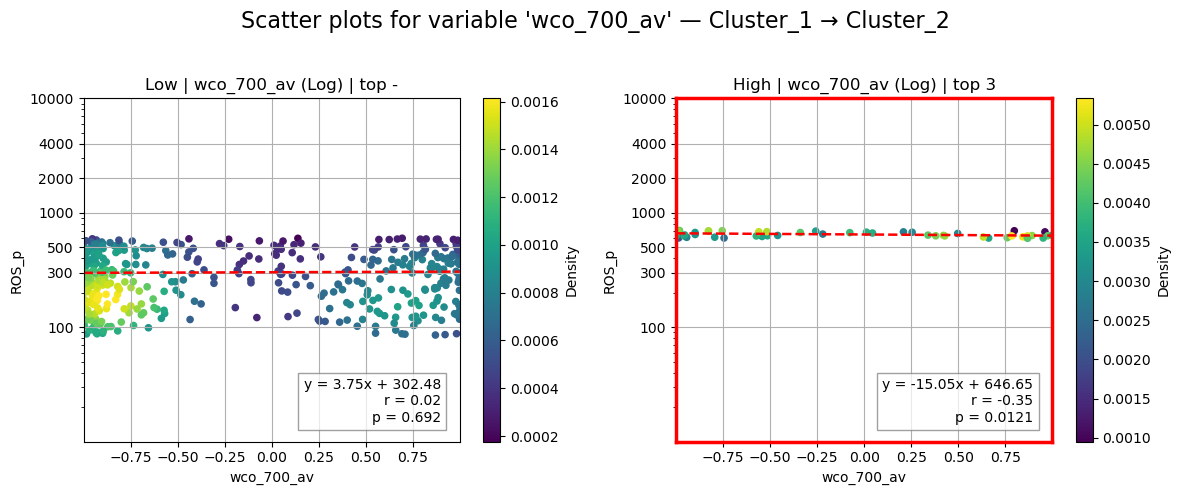

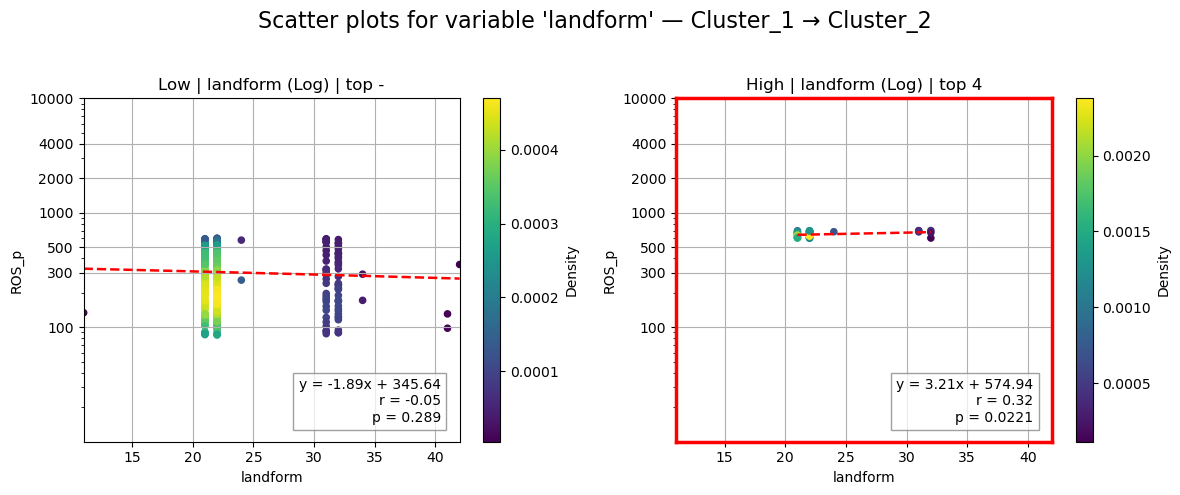

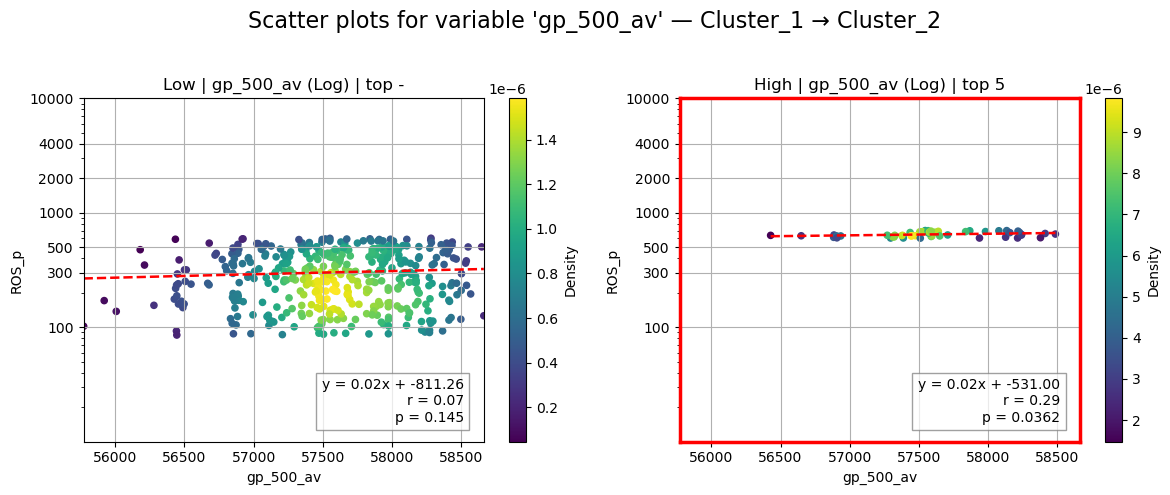

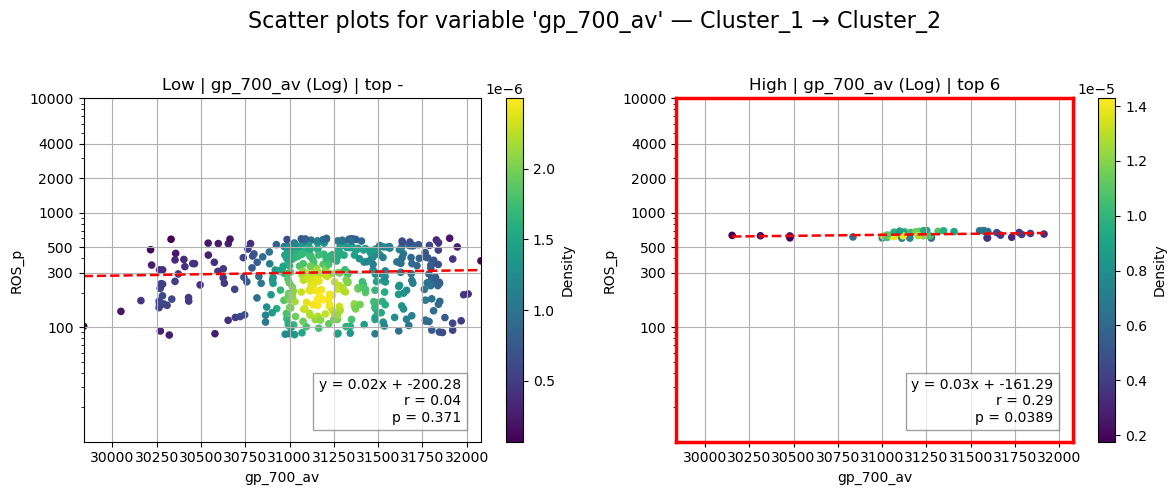

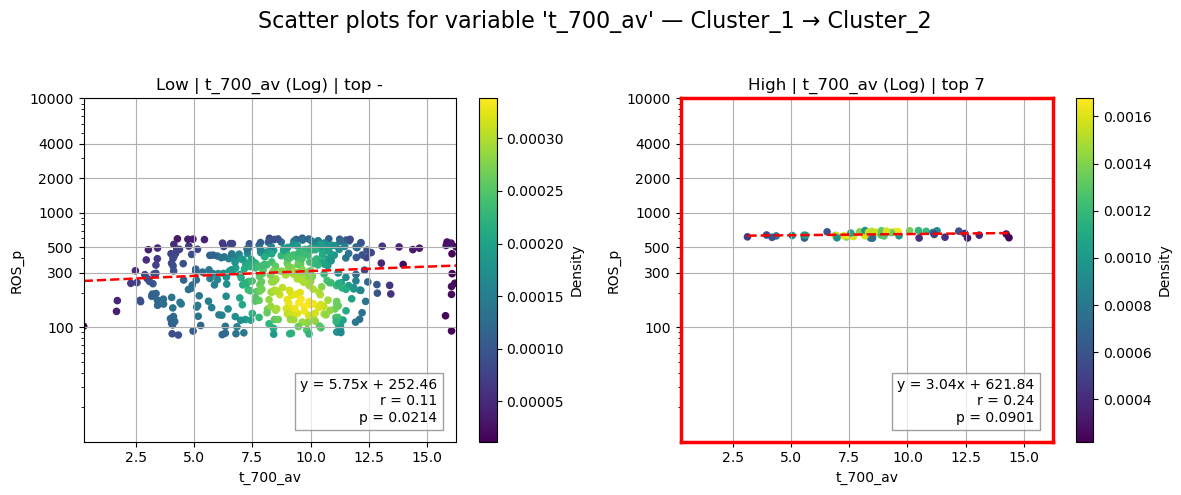

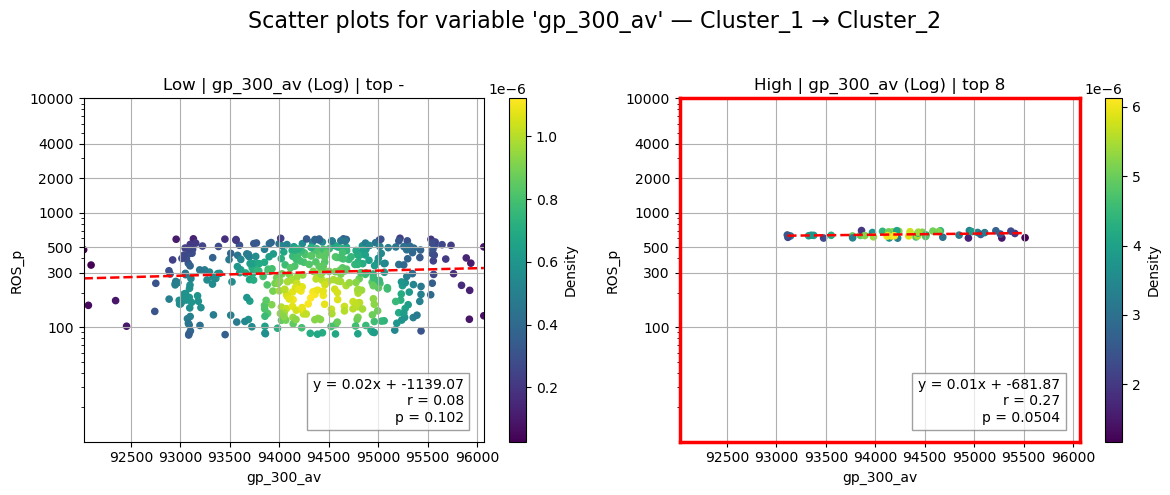

In [6]:
# ================================================
# SCATTER PLOTS FOR TOP 10 CLUSTERED VARIABLES ORDERED
# Cluster_1 → Cluster_2
# Regression line + equation in all plots
# ================================================

from scipy.stats import gaussian_kde, linregress
import matplotlib.pyplot as plt
import numpy as np

# ================= SIGNED LOG FUNCTION =================
def log_signed(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

# ================= PARAMETERS =================
TICK_Y = [100, 300, 500, 1000, 2000, 4000, 10000]
clusters_to_plot = ['Cluster_1', 'Cluster_2']

# ================= TOP VARIABLES AND GLOBAL TRANSFORMATION ===================
best_transformation = {}
top_ranking = {}

for cl, corrs in results.items():
    for rank, (v, trans_type, r_val, p_val) in enumerate(corrs[:20], start=1):
        best_transformation.setdefault(v, trans_type)
        top_ranking.setdefault(v, {})[cl] = rank

# ================= PLOT ORDER ===================
ordered_vars = []
seen = set()

for cl in clusters_to_plot:
    if cl not in results:
        continue
    for v, trans_type, r, p in results[cl][:20]:
        if v not in seen:
            ordered_vars.append(v)
            seen.add(v)

top_vars_sorted = ordered_vars

print("Clusters used:", clusters_to_plot)
print("Variables to plot:", top_vars_sorted)

# ================= SCATTER PLOTS ===================
for v in top_vars_sorted:
    plt.figure(figsize=(12, 5))

    # ---------- global X limits ----------
    x_all = []
    for cl in clusters_to_plot:
        dfc = gdf[gdf['cluster'] == cl]
        if v not in dfc.columns:
            continue
        mask = ~np.isnan(dfc[v].values) & ~np.isnan(dfc['ros_p'].values)
        x_all.append(dfc[v].values[mask])

    if not x_all:
        plt.close()
        continue

    x_all = np.concatenate(x_all)
    if len(x_all) < 2:
        plt.close()
        continue

    x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)

    # ---------- plots per cluster ----------
    for idx, cl in enumerate(clusters_to_plot):
        dfc = gdf[gdf['cluster'] == cl]
        if v not in dfc.columns:
            continue

        mask = ~np.isnan(dfc[v].values) & ~np.isnan(dfc['ros_p'].values)
        x, y = dfc[v].values[mask], dfc['ros_p'].values[mask]

        if len(x) < 2:
            continue

        trans_type = best_transformation.get(v, 'Lin')

        # ===== ALWAYS PLOT IN ORIGINAL SPACE =====
        x_plot, y_plot = x, y
        mask_plot = np.isfinite(x_plot) & np.isfinite(y_plot)
        x_plot, y_plot = x_plot[mask_plot], y_plot[mask_plot]

        if len(x_plot) < 2:
            continue

        # KDE
        try:
            xy = np.vstack([x_plot, y_plot])
            z = gaussian_kde(xy)(xy)
        except:
            z = np.ones_like(x_plot)

        ax = plt.subplot(1, 2, idx + 1)
        sc = ax.scatter(x_plot, y_plot, c=z, s=20, cmap='viridis')
        plt.colorbar(sc, ax=ax, label='Density')
        ax.grid(True)

        # ===== LINEAR REGRESSION (IN PLOT SPACE) =====
        try:
            slope, intercept, r_lin, p_lin, _ = linregress(x_plot, y_plot)

            x_fit = np.linspace(x_plot.min(), x_plot.max(), 200)
            y_fit = slope * x_fit + intercept
            ax.plot(x_fit, y_fit, color='red', linestyle='--', linewidth=1.8)

            eq_text = (
                f"y = {slope:.2f}x + {intercept:.2f}\n"
                f"r = {r_lin:.2f}\n"
                f"p = {p_lin:.3g}"
            )

            ax.text(
                0.95, 0.05, eq_text,
                transform=ax.transAxes,
                ha='right', va='bottom',
                fontsize=10,
                bbox=dict(facecolor='white', alpha=0.75, edgecolor='gray')
            )
        except:
            pass

        # ===== TITLE AND STYLE =====
        semantic = 'Low' if cl == 'Cluster_1' else 'High'
        rank_str = top_ranking.get(v, {}).get(cl, '-')

        ax.set_title(f"{semantic} | {v} ({trans_type}) | top {rank_str}", fontsize=12)
        ax.set_xlabel(v)
        ax.set_ylabel('ROS_p')

        if rank_str != '-':
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2.5)

        # Axes
        ax.set_yscale('log' if trans_type in ['Exp', 'Pow', 'Log'] else 'linear')
        ax.set_ylim(10, 10000)
        ax.set_yticks(TICK_Y)
        ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
        ax.set_xlim(x_min, x_max)

    plt.suptitle(f"Scatter plots for variable '{v}' — Cluster_1 → Cluster_2", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [7]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, linregress

# ================= SIGNED LOG FUNCTION =================
def log_signed(x):
    return np.sign(x) * np.log(np.abs(x) + 1)

# ================= PARAMETERS =================
clusters_to_export = ['Cluster_1', 'Cluster_2']
rows = []

# ================= MAIN LOOP =================
for cl in clusters_to_export:
    if cl not in results:
        continue

    dfc = gdf[gdf['cluster'] == cl]

    for v, trans_type, r_rank, p_rank in results[cl][:20]:

        if v not in dfc.columns:
            continue

        mask = ~np.isnan(dfc[v].values) & ~np.isnan(dfc['ros_p'].values)
        x = dfc[v].values[mask]
        y = dfc['ros_p'].values[mask]

        if len(x) < 3:
            continue

        # ===== TRANSFORMATIONS =====
        if trans_type == 'Lin':
            x_t, y_t = x, y
        elif trans_type == 'Log':
            x_t, y_t = log_signed(x), y
        elif trans_type == 'Exp':
            x_t, y_t = x, log_signed(y)
        elif trans_type == 'Pow':
            x_t, y_t = log_signed(x), log_signed(y)
        else:
            x_t, y_t = x, y

        mask_t = np.isfinite(x_t) & np.isfinite(y_t)
        x_t, y_t = x_t[mask_t], y_t[mask_t]

        if len(x_t) < 3:
            continue

        # ===== CORRELATION =====
        try:
            r_val, p_val = pearsonr(x_t, y_t)
        except:
            continue

        # ===== REGRESSION =====
        try:
            slope, intercept, r_lin, p_lin, _ = linregress(x_t, y_t)
            equation = f"y = {slope:.4f}x + {intercept:.4f}"
        except:
            slope, intercept = np.nan, np.nan
            equation = "NA"

        # ===== STORE RESULTS =====
        rows.append({
            'cluster': cl,
            'variable': v,
            'transformation': trans_type,
            'n_points': len(x_t),
            'corr_r': r_val,
            'corr_p': p_val,
            'slope': slope,
            'intercept': intercept,
            'equation': equation
        })

# ================= FINAL DATAFRAME =================
df_results = pd.DataFrame(rows)

# Sort for readability
df_results = df_results.sort_values(
    by=['cluster', 'corr_p', 'corr_r'],
    ascending=[True, True, False]
)

# ================= EXPORT =================
output_file = "correlations_regressions_clusters.csv"
df_results.to_csv(output_file, index=False)

print(f"Export completed: {output_file}")
print(df_results)


Export completed: correlations_regressions_clusters.csv
      cluster    variable transformation  n_points    corr_r        corr_p  \
0   Cluster_1      HDW_av            Lin       416  0.301335  3.519374e-10   
1   Cluster_1     dfmc_av            Pow       416 -0.274171  1.312201e-08   
2   Cluster_1   VPD_Pa_av            Exp       416  0.262666  5.418845e-08   
3   Cluster_1    rh_2m_av            Exp       416 -0.261002  6.615575e-08   
4   Cluster_1    BLH_m_av            Exp       416  0.241396  6.274045e-07   
5   Cluster_1  duration_p            Lin       416 -0.240697  6.774478e-07   
6   Cluster_1  LCL_hPa_av            Exp       416 -0.239797  7.475400e-07   
7   Cluster_1   t_2m_C_av            Exp       416  0.238460  8.646981e-07   
8   Cluster_1    LCL_m_av            Pow       416  0.237693  9.396962e-07   
9   Cluster_1     f_start            Log       416 -0.202765  3.092751e-05   
10  Cluster_1  wv10_kh_av            Log       416  0.199719  4.084911e-05   
11  Clus